In [1]:
import os
import sys
import json
import imgaug
import argparse
import cv2 as cv
from math import pi
import pandas as pd
import numpy as np
import skimage.draw
from fnmatch import fnmatch
from itertools import permutations
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

In [2]:
# Root directory of the project
ROOT_DIR = os.path.abspath("C:\\Users\\nidhimh\\Documents\\Mask_RCNN-master")

In [3]:
# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.config import Config
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import coco

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)


C:\Users\nidhimh\Anaconda3\envs\Tensor150\lib\site-packages\tensorflow\python\framework\dtypes.py:493: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\nidhimh\Anaconda3\envs\Tensor150\lib\site-packages\tensorflow\python\framework\dtypes.py:494: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\nidhimh\Anaconda3\envs\Tensor150\lib\site-packages\tensorflow\python\framework\dtypes.py:495: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\nidhimh\Anaconda3\envs\Tensor150\lib\site-pack

In [4]:
class FDDBConfig(Config):
    """Configuration for training on the toy  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "FDDB"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # Background + face

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 100
    
    # Number of ROIs
    TRAIN_ROIS_PER_IMAGE = 100

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9
    
config = FDDBConfig()
config.display()



Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [10]:
class FDDBDataset(utils.Dataset):

    def load_FDDB(self, dataset_dir, subset):
        """
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("face", 1, "face")
        
        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # Load annotations
        annotations = json.load(open(os.path.join(dataset_dir, "ellipse_json.json")))
        annotations = list(annotations.values())  # don't need the dict keys 
        
        annotations = [a for a in annotations if a['regions']]
        
        for a in annotations:
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. These are stores in the
            # shape_attributes (see json format above)
            # The if condition is needed to support VIA versions 1.x and 2.x.
            if type(a['regions']) is dict:
                ellipse = [r['shape_attributes'] for r in a['regions'].values()]
            else:
                ellipse = [r['shape_attributes'] for r in a['regions']] 

            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]
            
            self.add_image(
                "face",
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=ellipse)
            
            
                
    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "face":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)
            
    def load_mask(self, image_id):
        # If not a damage dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "face":
            return super(self.__class__, self).load_mask(image_id)
        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            if p['name'] == 'ellipse':
                rr, cc = skimage.draw.ellipse(p['cy'], p['cx'], p['ry'], p['rx'])
                mask[rr, cc, i] = 1

            elif (p['name'] == 'polygon') or (p['name'] == 'polyline'):
                rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
                mask[rr, cc, i] = 1

            else:
                raise Exception('Unknown annotation type. Supported annotation types: Polygon, Polyline, Ellipse.')

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)
    


In [11]:
dataset_train = FDDBDataset()
dataset_train.load_FDDB('C:\\Users\\nidhimh\\Documents\\Alignment', "train")
dataset_train.prepare()

In [12]:
dataset_val = FDDBDataset()
dataset_val.load_FDDB('C:\\Users\\nidhimh\\Documents\\Alignment', "val")
dataset_val.prepare()

C:\Users\nidhimh\Anaconda3\envs\Tensor150\lib\site-packages\PIL\TiffImagePlugin.py:811: UserWarning: Truncated File Read
  warnings.warn(str(msg))


In [13]:
model = modellib.MaskRCNN(mode="training", model_dir=MODEL_DIR, config=config)

In [14]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

In [15]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: C:\Users\nidhimh\Documents\Mask_RCNN-master\logs\fddb20210716T1715\mask_rcnn_fddb_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistr

C:\Users\nidhimh\Anaconda3\envs\Tensor150\lib\site-packages\tensorflow\python\ops\gradients_impl.py:97: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/1
 99/100 [============================>.] - ETA: 29s - loss: 1.4121 - rpn_class_loss: 0.0196 - rpn_bbox_loss: 0.4426 - mrcnn_class_loss: 0.0881 - mrcnn_bbox_loss: 0.5140 - mrcnn_mask_loss: 0.3478

C:\Users\nidhimh\Anaconda3\envs\Tensor150\lib\site-packages\PIL\TiffImagePlugin.py:811: UserWarning: Truncated File Read
  warnings.warn(str(msg))


100/100 [==============================] - 3505s 35s/step - loss: 1.4032 - rpn_class_loss: 0.0196 - rpn_bbox_loss: 0.4400 - mrcnn_class_loss: 0.0873 - mrcnn_bbox_loss: 0.5106 - mrcnn_mask_loss: 0.3458 - val_loss: 1.0729 - val_rpn_class_loss: 0.0166 - val_rpn_bbox_loss: 0.4279 - val_mrcnn_class_loss: 0.0335 - val_mrcnn_bbox_loss: 0.3505 - val_mrcnn_mask_loss: 0.2444


In [16]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2, 
            layers="all")


Starting at epoch 1. LR=0.0001

Checkpoint Path: C:\Users\nidhimh\Documents\Mask_RCNN-master\logs\fddb20210716T1715\mask_rcnn_fddb_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         

C:\Users\nidhimh\Anaconda3\envs\Tensor150\lib\site-packages\tensorflow\python\ops\gradients_impl.py:97: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 2/2
 42/100 [===========>..................] - ETA: 2:29:51 - loss: 0.6740 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.2087 - mrcnn_class_loss: 0.0445 - mrcnn_bbox_loss: 0.1979 - mrcnn_mask_loss: 0.2122

ERROR:root:Error processing image {'id': 'img_350.jpg', 'source': 'face', 'path': 'C:\\Users\\nidhimh\\Documents\\Alignment\\train\\img_350.jpg', 'width': 369, 'height': 450, 'polygons': [{'name': 'ellipse', 'cx': 125, 'cy': 213, 'rx': 138.232, 'ry': 241, 'theta': -0.058}]}
Traceback (most recent call last):
  File "C:\Users\nidhimh\Documents\Mask_RCNN-master\mrcnn\model.py", line 1709, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "C:\Users\nidhimh\Documents\Mask_RCNN-master\mrcnn\model.py", line 1212, in load_image_gt
    mask, class_ids = dataset.load_mask(image_id)
  File "<ipython-input-10-e3c94fb25342>", line 68, in load_mask
    mask[rr, cc, i] = 1
IndexError: index 450 is out of bounds for axis 0 with size 450


 99/100 [============================>.] - ETA: 1:38 - loss: 0.6703 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.1982 - mrcnn_class_loss: 0.0396 - mrcnn_bbox_loss: 0.1942 - mrcnn_mask_loss: 0.2290

C:\Users\nidhimh\Anaconda3\envs\Tensor150\lib\site-packages\PIL\TiffImagePlugin.py:811: UserWarning: Truncated File Read
  warnings.warn(str(msg))


100/100 [==============================] - 10479s 105s/step - loss: 0.6684 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.1966 - mrcnn_class_loss: 0.0396 - mrcnn_bbox_loss: 0.1941 - mrcnn_mask_loss: 0.2288 - val_loss: 0.5663 - val_rpn_class_loss: 0.0068 - val_rpn_bbox_loss: 0.1371 - val_mrcnn_class_loss: 0.0300 - val_mrcnn_bbox_loss: 0.1699 - val_mrcnn_mask_loss: 0.2226


In [18]:
class FDDBInferenceConfig(FDDBConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = FDDBInferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  C:\Users\nidhimh\Documents\Mask_RCNN-master\logs\fddb20210716T1715\mask_rcnn_fddb_0002.h5
Re-starting from epoch 2


In [22]:
image = skimage.io.imread("C:\\Users\\nidhimh\\Downloads\\0013\\121a.jpg")

In [23]:
r = model.detect([image], verbose=0)[0]

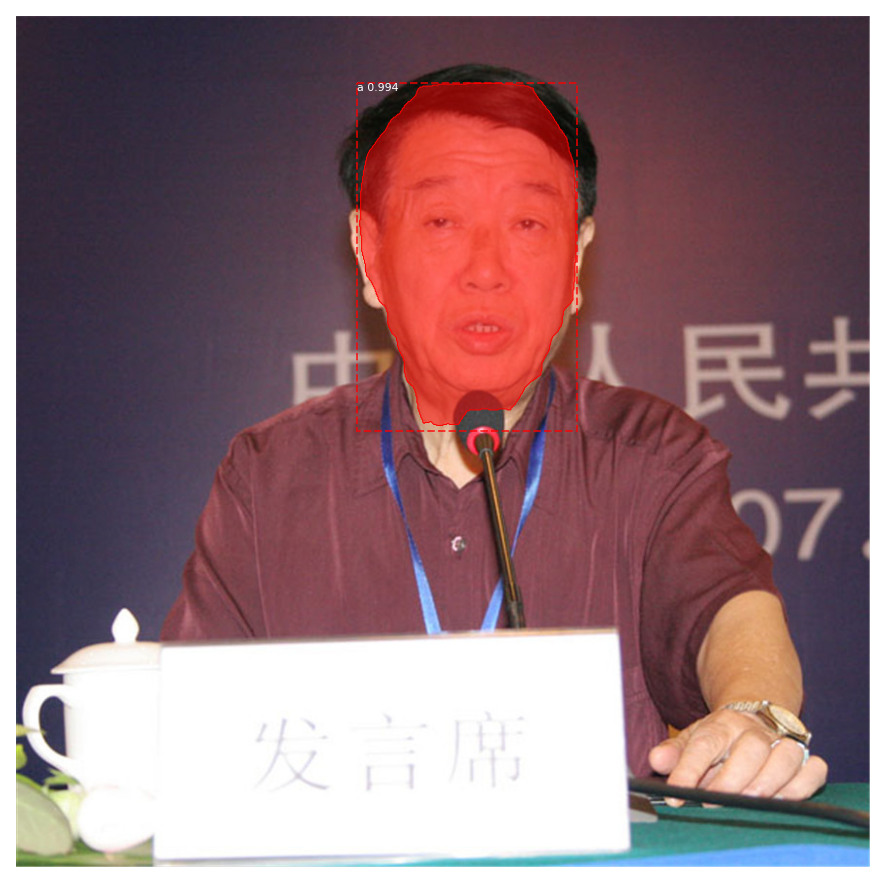

In [50]:
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 'face', scores=r['scores'])

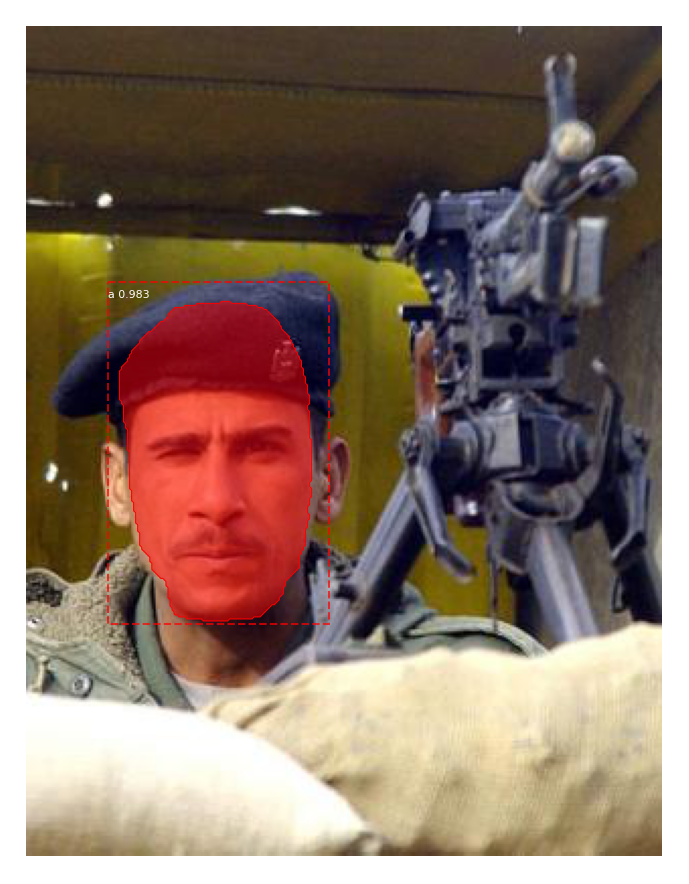

In [52]:
image = skimage.io.imread("C:\\Users\\nidhimh\\Downloads\\originalPics\\2003\\02\\03\\big\\img_7.jpg")
r = model.detect([image], verbose=0)[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 'face', scores=r['scores'])

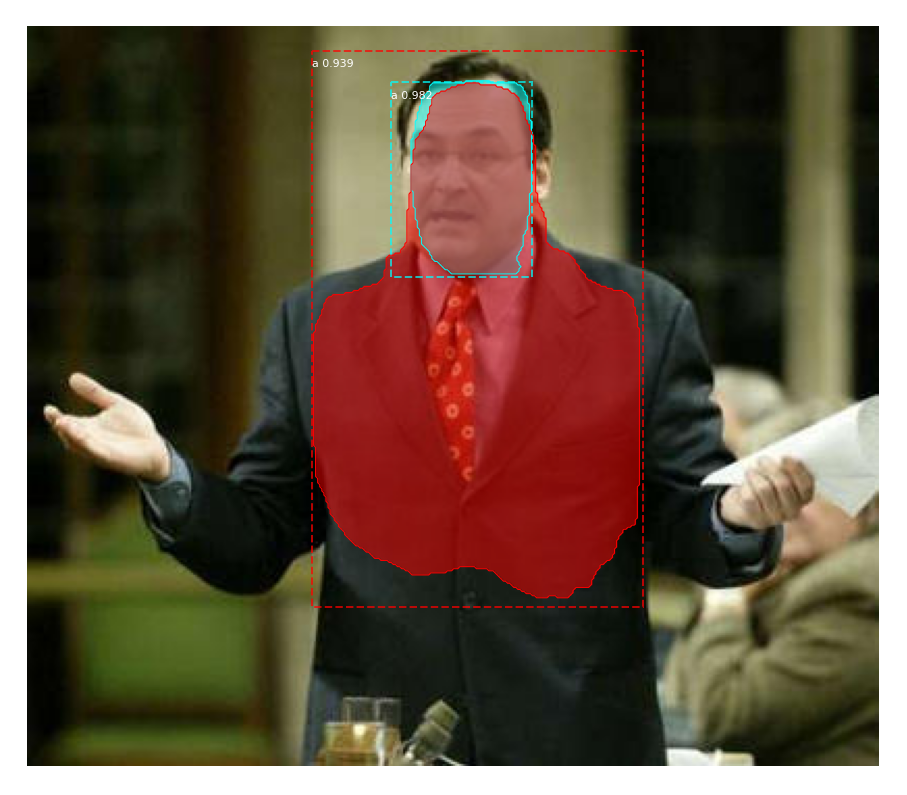

In [53]:
image = skimage.io.imread("C:\\Users\\nidhimh\\Downloads\\originalPics\\2003\\02\\03\\big\\img_310.jpg")
r = model.detect([image], verbose=0)[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 'face', scores=r['scores'])

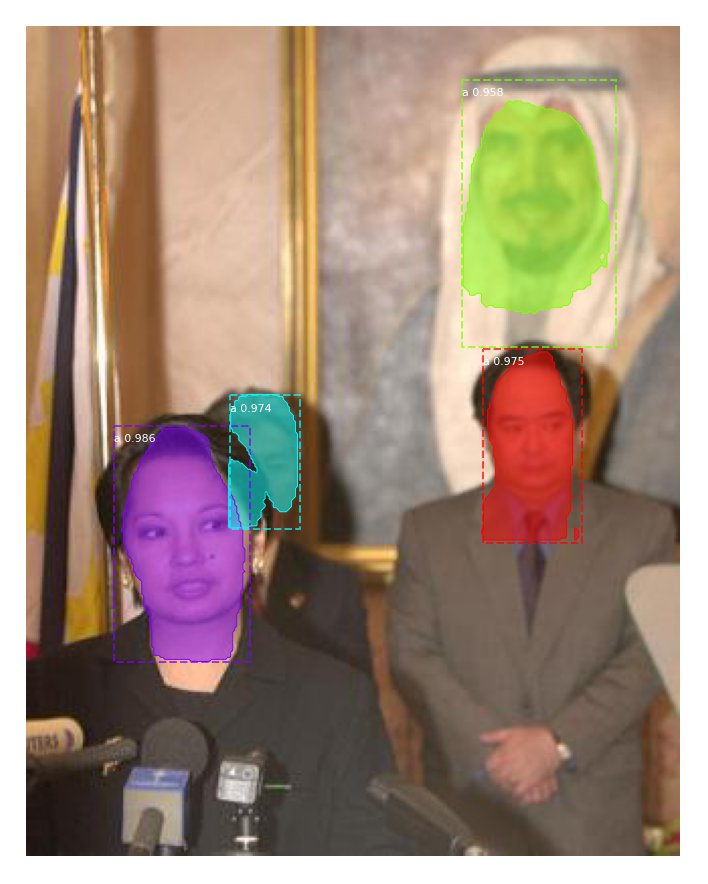

In [54]:
image = skimage.io.imread("C:\\Users\\nidhimh\\Downloads\\originalPics\\2003\\02\\03\\big\\img_700.jpg")
r = model.detect([image], verbose=0)[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 'face', scores=r['scores'])

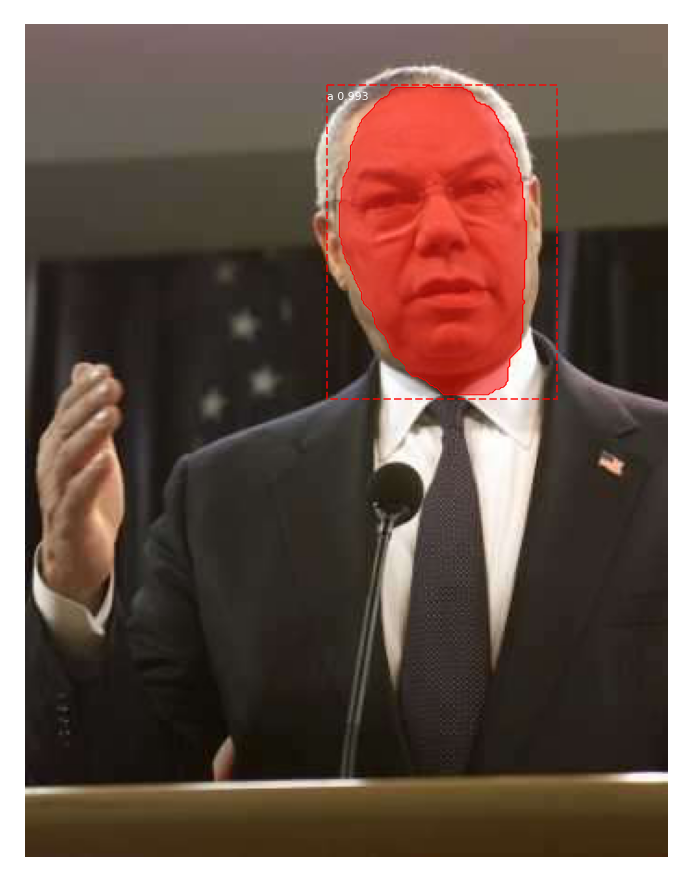

In [55]:
image = skimage.io.imread("C:\\Users\\nidhimh\\Downloads\\originalPics\\2003\\02\\03\\big\\img_922.jpg")
r = model.detect([image], verbose=0)[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 'face', scores=r['scores'])

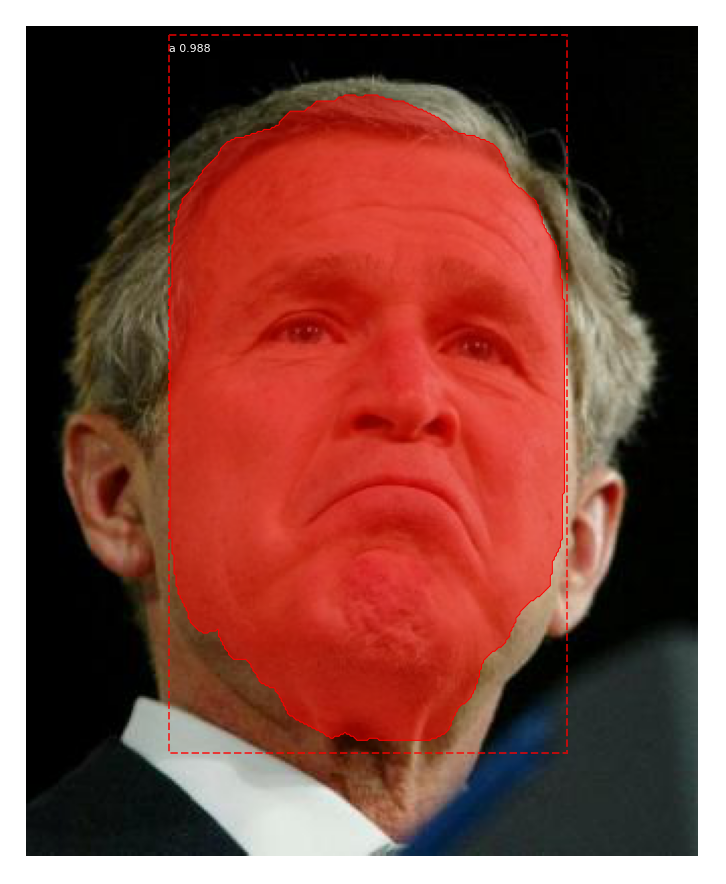

In [56]:
image = skimage.io.imread("C:\\Users\\nidhimh\\Downloads\\originalPics\\2003\\02\\03\\big\\img_440.jpg")
r = model.detect([image], verbose=0)[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 'face', scores=r['scores'])